In [1]:
from __future__ import absolute_import, division, print_function, unicode_literals
import matplotlib.pylab as plt
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
import statistics
from keras.models import Sequential
from keras.layers.core import Dense, Dropout, Flatten
from keras.layers import MaxPool2D
from keras.layers.convolutional import Conv2D
from sklearn.model_selection import KFold

In [2]:
pd.set_option("display.precision", 8)

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
import warnings
warnings.filterwarnings('ignore')

In [4]:
data_root='/content/drive/MyDrive/masknomass/data'

In [6]:
IMAGE_SHAPE = (224, 224)
TRAINING_DATA_DIR = str(data_root)
print(TRAINING_DATA_DIR);
datagen_kwargs = dict(rescale=1./255, validation_split=0.5)
valid_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
valid_generator = valid_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="validation",
shuffle=True,
target_size=IMAGE_SHAPE
)
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(**datagen_kwargs)
train_generator = train_datagen.flow_from_directory(
TRAINING_DATA_DIR,
subset="training",
shuffle=True,
target_size=IMAGE_SHAPE)

/content/drive/MyDrive/masknomass/data
Found 3776 images belonging to 2 classes.
Found 3777 images belonging to 2 classes.


In [7]:
image_batch_train, label_batch_train = next(iter(train_generator))
print("Image batch shape: ", image_batch_train.shape)
print("Label batch shape: ", label_batch_train.shape)
dataset_labels = sorted(train_generator.class_indices.items(), key=lambda pair:pair[1])
dataset_labels = np.array([key.title() for key, value in dataset_labels])
print(dataset_labels)

Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 2)
['With_Mask' 'Without_Mask']


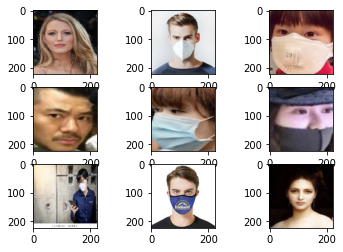

In [8]:
for i in range(9):
  plt.subplot(330 + 1 + i)
  plt.imshow(image_batch_train[i])
plt.show()

In [9]:
for i in range(9):
  # plt.subplot(330 + 1 + i)
  print(label_batch_train[i])
  # plt.imshow(image_batch_train[i])
# plt.show()

[0. 1.]
[1. 0.]
[1. 0.]
[0. 1.]
[1. 0.]
[1. 0.]
[1. 0.]
[1. 0.]
[0. 1.]


Random Forest on n no of batches of training images

In [10]:
from sklearn.ensemble import RandomForestClassifier
rf=RandomForestClassifier()
folds=3
fold_scores=[]

for i in range(folds):
  batches = 0
  for j in range(50): 
        x_batch, y_batch = next(iter(train_generator))
        x_batch=x_batch.reshape(-1,150528)
        rf.fit(x_batch, y_batch)

  each_batch_score=[]
  for j in range(50): 
    x_batch, y_batch = next(iter(valid_generator))
    x_batch=x_batch.reshape(-1,150528)
    each_batch_score.append(rf.score(x_batch,y_batch))
  accuracy=statistics.mean(each_batch_score)

  print(f"Score for fold {i} :", accuracy)
  fold_scores.append(accuracy)

print("Accuracy: ",statistics.mean(fold_scores))

Score for fold 0 : 0.56125
Score for fold 1 : 0.65
Score for fold 2 : 0.603125
Accuracy:  0.6047916666666667


KNN

In [11]:
from sklearn.neighbors import KNeighborsClassifier
neigh = KNeighborsClassifier(n_neighbors=10)
folds=3
fold_scores=[]

for i in range(folds):
  batches = 0
  for j in range(50): 
      x_batch, y_batch = next(iter(train_generator))
      x_batch=x_batch.reshape(-1,150528)
      neigh.fit(x_batch, y_batch)

  each_batch_score=[]
  for j in range(50): 
      x_batch, y_batch = next(iter(valid_generator))
      x_batch=x_batch.reshape(-1,150528)
      each_batch_score.append(neigh.score(x_batch,y_batch))
  accuracy=statistics.mean(each_batch_score)

  print(f"Score for fold {i} :", accuracy)
  fold_scores.append(accuracy)

print("Accuracy: ",statistics.mean(fold_scores))

Score for fold 0 : 0.435625
Score for fold 1 : 0.44625
Score for fold 2 : 0.380625
Accuracy:  0.42083333333333334


ADABOOST

In [12]:
from sklearn.ensemble import AdaBoostClassifier
clf = AdaBoostClassifier(n_estimators=100, random_state=0)
folds=3
fold_scores=[]

for i in range(folds):
  batches = 0
  for j in range(50): 
        x_batch, y_batch = next(iter(train_generator))
        x_batch=x_batch.reshape(-1,150528)
        y=[]
        for i in y_batch:
          if(i[0]==1):
            y.append(0)
          else:
            y.append(1)
        clf.fit(x_batch, y)

  each_batch_score=[]
  for j in range(50): 
        x_batch, y_batch = next(iter(valid_generator))
        x_batch=x_batch.reshape(-1,150528)
        y=[]
        for i in y_batch:
          if(i[0]==1):
            y.append(0)
          else:
            y.append(1)
        each_batch_score.append(clf.score(x_batch,y))
  accuracy=statistics.mean(each_batch_score)
  print(f"Score for fold {i} :", accuracy)
  fold_scores.append(accuracy)

print("Accuracy: ",statistics.mean(fold_scores))

Score for fold [1. 0.] : 0.513125
Score for fold [0. 1.] : 0.554375
Score for fold [0. 1.] : 0.713125
Accuracy:  0.5935416666666666


CNN

In [ ]:
acc_per_fold = []
loss_per_fold = []
#number of folds taken is 3
num_folds=3
kfold = KFold(n_splits=num_folds, shuffle=True)
fold_no = 1
# for train, test in kfold.split(inputs, targets):
  #defining the network
cnn = Sequential()
cnn.add(Conv2D(filters=16, kernel_size=(3,3),input_shape=(224,224,3), activation='relu',))
# cnn.add(Flatten())
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Conv2D(filters=32, kernel_size=(3,3), activation='relu',))
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Conv2D(filters=64, kernel_size=(3,3), activation='relu',))
cnn.add(MaxPool2D(pool_size=(2, 2)))
cnn.add(Flatten())
cnn.add(Dense(1024, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(64, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(32, activation='relu'))
cnn.add(Dropout(0.2))
cnn.add(Dense(2, activation='softmax'))
  #compiling the network
cnn.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
  #fitting the network
history=[]
for i in range(num_folds):
     print("Training on Fold: ",i+1)
     history=cnn.fit(train_generator, validation_data=valid_generator,steps_per_epoch=100,epochs=5,validation_steps=100,verbose=1)
     x_batch, y_batch = next(iter(valid_generator))
     score = cnn.evaluate(x_batch, y_batch, verbose=0)
     acc_per_fold.append(score[1] * 100)
     loss_per_fold.append(score[0])
     print(f'Score for fold {i+1}: {cnn.metrics_names[0]} of {score[0]}; {cnn.metrics_names[1]} of {score[1]*100}%')

  #Average results
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

Training on Fold:  1
Epoch 1/5
100/100 [==============================] - 873s 9s/step - loss: 0.7041 - accuracy: 0.6282 - val_loss: 0.3461 - val_accuracy: 0.8641
Epoch 2/5
100/100 [==============================] - 291s 3s/step - loss: 0.2914 - accuracy: 0.8775 - val_loss: 0.4408 - val_accuracy: 0.8519
Epoch 3/5
100/100 [==============================] - 207s 2s/step - loss: 0.2440 - accuracy: 0.9013 - val_loss: 0.3043 - val_accuracy: 0.8822
Epoch 4/5
100/100 [==============================] - 202s 2s/step - loss: 0.2067 - accuracy: 0.9257 - val_loss: 0.3397 - val_accuracy: 0.8828
Epoch 5/5
100/100 [==============================] - 204s 2s/step - loss: 0.1567 - accuracy: 0.9353 - val_loss: 0.4214 - val_accuracy: 0.8725
Score for fold 1: loss of 0.2712080478668213; accuracy of 90.625%
Training on Fold:  2
Epoch 1/5
100/100 [==============================] - 205s 2s/step - loss: 0.1290 - accuracy: 0.9546 - val_loss: 0.4293 - val_accuracy: 0.8828
Epoch 2/5
100/100 [=====================

MLP

In [13]:
acc_per_fold = []
loss_per_fold = []
#number of folds taken is 3
number_folds=3
kfold = KFold(n_splits=number_folds, shuffle=True)
fold_no = 1
mlp = Sequential()
mlp.add(Flatten())
mlp.add(Dense(2050,activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(1030, activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(510,activation='relu'))
mlp.add(Dropout(0.2))
mlp.add(Dense(2, activation='softmax'))
#compiling the network
mlp.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print('------------------------------------------------------------------------')
for i in range(number_folds):
     print("Training on Fold: ",i+1)
     history=mlp.fit(train_generator, validation_data=valid_generator,steps_per_epoch=100,epochs=3,validation_steps=100,verbose=1)
     x_batch, y_batch = next(iter(valid_generator))
     score = mlp.evaluate(x_batch, y_batch, verbose=0)
     acc_per_fold.append(score[1] * 100)
     loss_per_fold.append(score[0])
     print(f'Score for fold {i+1}: {mlp.metrics_names[0]} of {score[0]}; {mlp.metrics_names[1]} of {score[1]*100}%')

  #Average results
print('------------------------------------------------------------------------')
print('Score per fold')
for i in range(0, len(acc_per_fold)):
  print('------------------------------------------------------------------------')
  print(f'> Fold {i+1} - Loss: {loss_per_fold[i]} - Accuracy: {acc_per_fold[i]}%')
print('------------------------------------------------------------------------')
print('Average scores for all folds:')
print(f'> Accuracy: {np.mean(acc_per_fold)} (+- {np.std(acc_per_fold)})')
print(f'> Loss: {np.mean(loss_per_fold)}')
print('------------------------------------------------------------------------')

------------------------------------------------------------------------
Training on Fold:  1
Epoch 1/3
100/100 [==============================] - 274s 3s/step - loss: 47.0902 - accuracy: 0.5252 - val_loss: 2.1475 - val_accuracy: 0.5175
Epoch 2/3
100/100 [==============================] - 257s 3s/step - loss: 2.0673 - accuracy: 0.6134 - val_loss: 0.5938 - val_accuracy: 0.6834
Epoch 3/3
100/100 [==============================] - 272s 3s/step - loss: 0.6571 - accuracy: 0.7375 - val_loss: 0.5240 - val_accuracy: 0.7519
Score for fold 1: loss of 0.4072396755218506; accuracy of 78.125%
Training on Fold:  2
Epoch 1/3
100/100 [==============================] - 263s 3s/step - loss: 0.5099 - accuracy: 0.7775 - val_loss: 0.4585 - val_accuracy: 0.8016
Epoch 2/3
100/100 [==============================] - 268s 3s/step - loss: 0.5132 - accuracy: 0.7725 - val_loss: 0.5163 - val_accuracy: 0.7472
Epoch 3/3
100/100 [==============================] - 263s 3s/step - loss: 0.4574 - accuracy: 0.7955 - val_lo